# Pyro Examples

In [1]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [3]:
DATA_FILE = "./data/iclaims_example.csv"

In [4]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

### Train / Test Split

In [5]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.18397,0.72014,1.11967
1,2010-01-10,825891,1.18397,0.81490,1.17860
2,2010-01-17,659173,1.20338,0.73909,1.11967
3,2010-01-24,507651,1.16456,0.81490,1.10788
4,2010-01-31,538617,1.08693,0.77699,1.07253


## MAP Fit and Predict

In [7]:
lgt_map=LGT(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    sample_method='map',
    predict_method='map',
    auto_scale=False,
    is_multiplicative=True
)

In [8]:
lgt_map.fit(df=train_df)

In [9]:
predicted_df = lgt_map.predict(df=test_df)

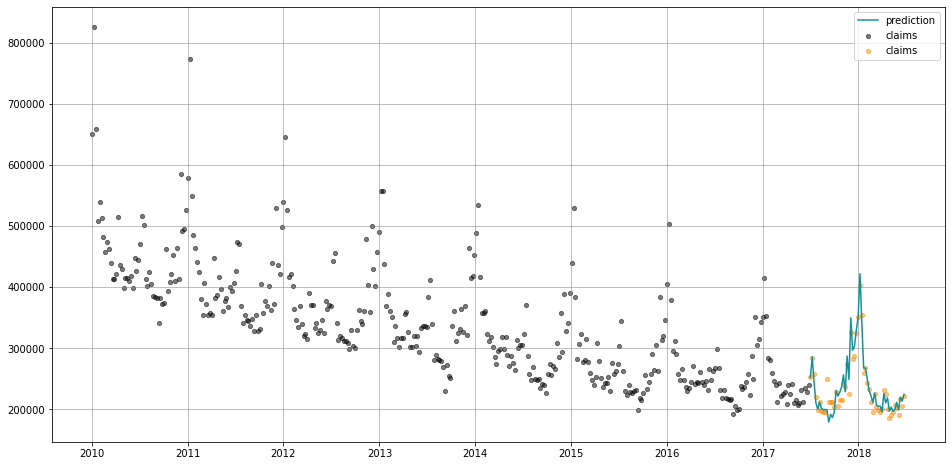

In [10]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.

In [11]:
lgt_vi = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    seed=8888,
    inference_engine='pyro',
    sample_method='vi',
    predict_method='full',
    n_bootstrap_draws=500
)

In [12]:
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


In [13]:
predicted_df = lgt_vi.predict(df=test_df)

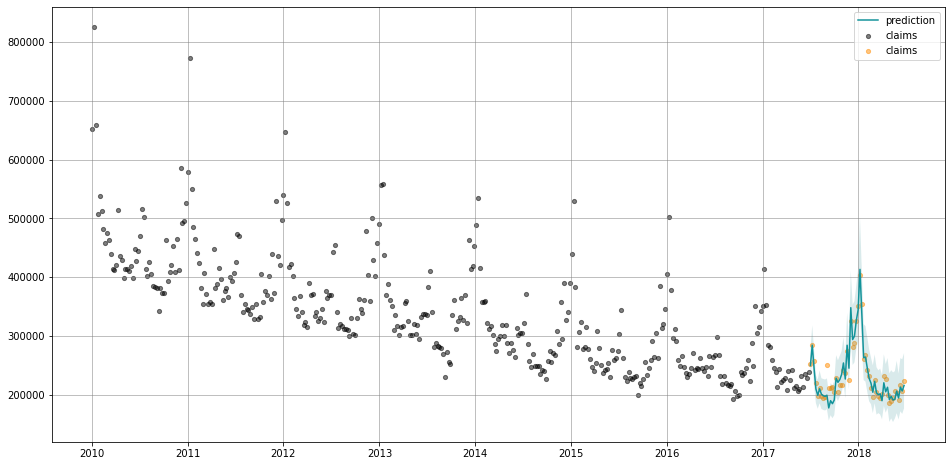

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Fit with Regressors

In [15]:
lgt_reg_map=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_sign=['=','='],
    date_col='week',
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    sample_method='map',
    predict_method='map'
)

In [16]:
lgt_reg_map.fit(df=train_df)

In [17]:
predicted_df = lgt_reg_map.predict(df=test_df)

In [18]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,253391.99012
1,2017-07-09,287145.47144
2,2017-07-16,244975.81356
3,2017-07-23,209939.21175
4,2017-07-30,202148.37793


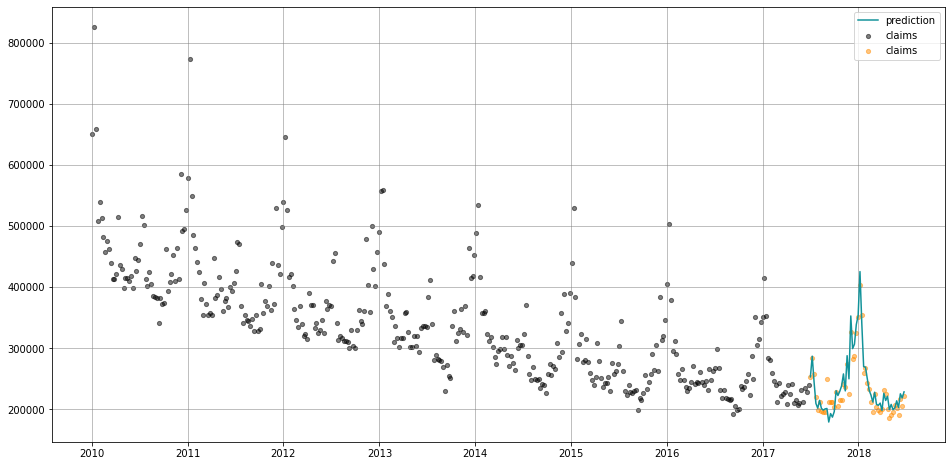

In [19]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_reg_map.date_col, actual_col=lgt_reg_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [20]:
predicted_df = lgt_reg_map.predict(df=df, decompose=True)
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2010-01-03,893467.02071,663766.54347,1.37200,0.98109
1,2010-01-10,1736201.71441,661383.87529,2.64523,0.99239
2,2010-01-17,730851.24808,519502.80649,1.42894,0.98453
3,2010-01-24,558083.31761,521445.19489,1.07966,0.99129
4,2010-01-31,567484.79543,516161.55378,1.11916,0.98237


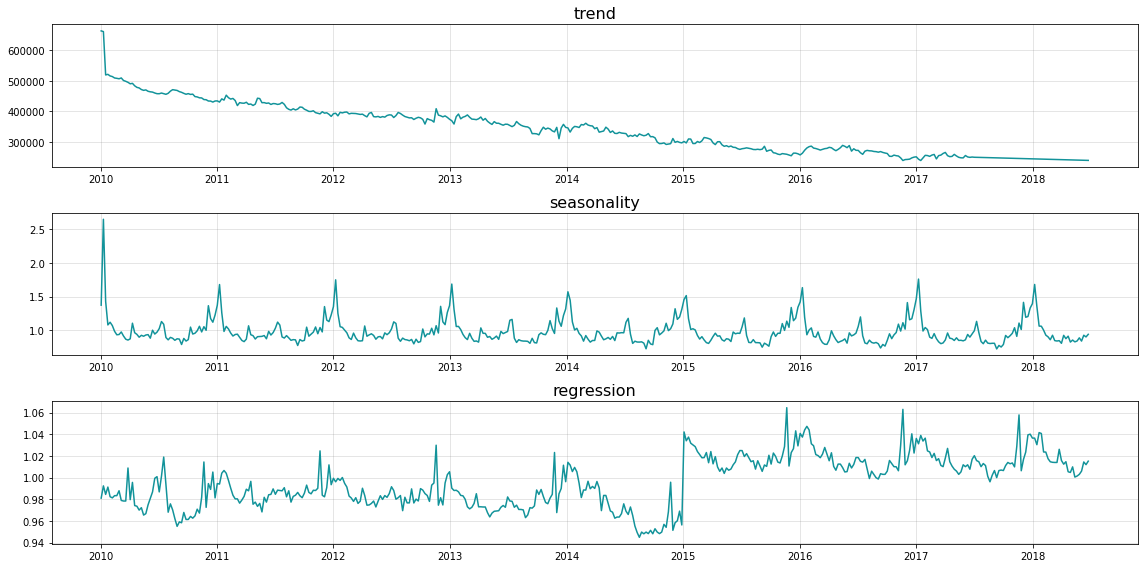

In [21]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')